In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from model import Net
from custom_transforms import QuantizeBatch

from torch.utils.tensorboard import SummaryWriter

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

BATCH_SIZE=64

testset = torchvision.datasets.KMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
lmbda = 100.
net_protected = Net(reg_param=lmbda)
net_protected.load(name=f'q_kmnist_lambda{lmbda}')
net_protected.eval()

net = Net(reg_param=0.)
net.load(name=f'kmnist_lambda100.0')
net.eval()
print(net)

re_param: 100.0
re_param: 0.0
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (act): Softmax(dim=-1)
)


In [4]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def test_attack( model, model_protected, test_loader, epsilon, defense=False, epoch=0):

    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(model.device), target.to(model.device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model_protected(data)
        init_pred = torch.argmax(output, axis=1)
        #init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        #if init_pred.item() != target.item():
            #continue

        output = model(data)
            
        # Calculate the loss
        loss = model.loss_fn(output, target, data, regularize_grads=False)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        #perturbed_data = data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        if defense:
            perturbed_data = QuantizeBatch(perturbed_data)

        # Re-classify the perturbed image
        output = model_protected(perturbed_data)

        # Check for success
        final_pred = torch.argmax(output, axis=1)
        #final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        correct += (final_pred[init_pred == target] == init_pred[init_pred == target]).float().sum()
        total += final_pred.shape[0]
        '''if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                data_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, data_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                data_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, data_ex) )'''

    # Calculate final accuracy for this epsilon
    final_acc = correct/total
    #final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {:.4f}".format(epsilon, correct, total, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

def test(net, dataloader):
    correct = 0.
    total = 0.
    loss = 0.
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(net.device), data[1].to(net.device)
            outputs = net(images)
            run_loss = net.loss_fn(outputs, labels, images, regularize_grads=False).item()
            loss += run_loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            run_acc = (predicted == labels).sum().item()
            correct += run_acc

    return correct / total * 100, loss / len(dataloader)

In [5]:
reg_vs_regtrained_accuracies = []
reg_vs_regtrained_examples = []

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_attack(net, net_protected, testloader, eps)
    reg_vs_regtrained_accuracies.append(acc)
    reg_vs_regtrained_examples.append(ex)

'''Epsilon: 0.1	Test Accuracy = 8217.0 / 10000 = 0.8217
Epsilon: 0.2	Test Accuracy = 5249.0 / 10000 = 0.5249
Epsilon: 0.5	Test Accuracy = 339.0 / 10000 = 0.0339
Epsilon: 0.9	Test Accuracy = 172.0 / 10000 = 0.0172'''

Epsilon: 0.1	Test Accuracy = 8633.0 / 10000 = 0.8633
Epsilon: 0.2	Test Accuracy = 6877.0 / 10000 = 0.6877
Epsilon: 0.3	Test Accuracy = 4503.0 / 10000 = 0.4503
Epsilon: 0.4	Test Accuracy = 2396.0 / 10000 = 0.2396
Epsilon: 0.5	Test Accuracy = 1234.0 / 10000 = 0.1234
Epsilon: 0.6	Test Accuracy = 652.0 / 10000 = 0.0652
Epsilon: 0.7	Test Accuracy = 396.0 / 10000 = 0.0396
Epsilon: 0.8	Test Accuracy = 296.0 / 10000 = 0.0296
Epsilon: 0.9	Test Accuracy = 261.0 / 10000 = 0.0261


'Epsilon: 0.1\tTest Accuracy = 8217.0 / 10000 = 0.8217\nEpsilon: 0.2\tTest Accuracy = 5249.0 / 10000 = 0.5249\nEpsilon: 0.5\tTest Accuracy = 339.0 / 10000 = 0.0339\nEpsilon: 0.9\tTest Accuracy = 172.0 / 10000 = 0.0172'

In [6]:
reg_vs_qregtrained_accuracies = []
reg_vs_qregtrained_examples = []
print('With defense:')
for eps in epsilons:
    acc, ex = test_attack(net, net_protected, testloader, eps, defense=True)
    reg_vs_qregtrained_accuracies.append(acc)
    reg_vs_qregtrained_examples.append(ex)
    
'''Epsilon: 0.1	Test Accuracy = 8992.0 / 10000 = 0.8992
Epsilon: 0.2	Test Accuracy = 8016.0 / 10000 = 0.8016
Epsilon: 0.5	Test Accuracy = 3950.0 / 10000 = 0.3950
Epsilon: 0.9	Test Accuracy = 885.0 / 10000 = 0.0885'''

With defense:
Epsilon: 0.1	Test Accuracy = 8986.0 / 10000 = 0.8986
Epsilon: 0.2	Test Accuracy = 8297.0 / 10000 = 0.8297
Epsilon: 0.3	Test Accuracy = 7404.0 / 10000 = 0.7404
Epsilon: 0.4	Test Accuracy = 6325.0 / 10000 = 0.6325
Epsilon: 0.5	Test Accuracy = 5269.0 / 10000 = 0.5269
Epsilon: 0.6	Test Accuracy = 4238.0 / 10000 = 0.4238
Epsilon: 0.7	Test Accuracy = 3343.0 / 10000 = 0.3343
Epsilon: 0.8	Test Accuracy = 2516.0 / 10000 = 0.2516
Epsilon: 0.9	Test Accuracy = 1752.0 / 10000 = 0.1752


'Epsilon: 0.1\tTest Accuracy = 8992.0 / 10000 = 0.8992\nEpsilon: 0.2\tTest Accuracy = 8016.0 / 10000 = 0.8016\nEpsilon: 0.5\tTest Accuracy = 3950.0 / 10000 = 0.3950\nEpsilon: 0.9\tTest Accuracy = 885.0 / 10000 = 0.0885'

In [7]:
from skimage.io import imsave, imread
SAVE_IMAGES=False

if SAVE_IMAGES:
    for i, eps in enumerate(epsilons):
        for j in range(5):
            orig, adv, ex, clean = examples[i][j]
            img = ex
            img -= np.min(img)
            img /= np.max(img)
            imsave(f'kmnist_filtered_examples/{eps}/{j+1}/adversarial.png', (img * 255).astype(np.uint8))
            img = clean
            img -= np.min(img)
            img /= np.max(img)
            imsave(f'kmnist_filtered_examples/{eps}/{j+1}/clean.png', (img * 255).astype(np.uint8))
            img = (ex - clean)
            img -= np.min(img)
            img /= np.max(img)
            imsave(f'kmnist_filtered_examples/{eps}/{j+1}/diff.png', (img * 255).astype(np.uint8))

In [8]:
#acc, ex = test(net, testloader)
'''fig = plt.figure(figsize=(15, 7))

eps_ind, ex_ind = 0, 1
dataset = 'kmnist_filtered_examples'
ex = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/adversarial.png')
ex = ex / 255.
clean = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/clean.png')
clean = clean / 255.
diff = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/diff.png')
diff = diff / 255.

ax = fig.add_subplot(1, 3, 1)
plt.imshow(ex)
ax.set_title('adversarial')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(clean)
ax.set_title('clean')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(diff)
ax.set_title('diff')'''

"fig = plt.figure(figsize=(15, 7))\n\neps_ind, ex_ind = 0, 1\ndataset = 'kmnist_filtered_examples'\nex = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/adversarial.png')\nex = ex / 255.\nclean = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/clean.png')\nclean = clean / 255.\ndiff = imread(f'{dataset}/{epsilons[eps_ind]}/{ex_ind}/diff.png')\ndiff = diff / 255.\n\nax = fig.add_subplot(1, 3, 1)\nplt.imshow(ex)\nax.set_title('adversarial')\n\nax = fig.add_subplot(1, 3, 2)\nplt.imshow(clean)\nax.set_title('clean')\n\nax = fig.add_subplot(1, 3, 3)\nplt.imshow(diff)\nax.set_title('diff')"

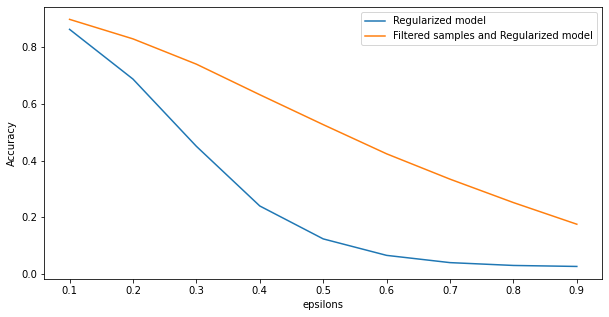

In [9]:
fig = plt.figure(figsize=(10, 5))

#ax = fig.add_subplot(1, 2, 1)
plt.xlabel('epsilons')
plt.ylabel('Accuracy')
plt.plot(epsilons, reg_vs_regtrained_accuracies if reg_vs_regtrained_accuracies else np.loadtxt('reg_vs_regtrained.txt'), label='Regularized model')
plt.plot(epsilons, reg_vs_qregtrained_accuracies if reg_vs_qregtrained_accuracies else np.loadtxt('reg_vs_qregtrained.txt'), label='Filtered samples and Regularized model')
plt.legend()

plt.savefig('reg_vs_regtrained_and_qregtrained.png')

In [10]:
SAVE = True

if SAVE:
    np.savetxt('epsilons.txt', np.array(epsilons))
    np.savetxt('reg_vs_regtrained.txt', np.array(reg_vs_regtrained_accuracies))
    np.savetxt('reg_vs_qregtrained.txt', np.array(reg_vs_qregtrained_accuracies))